In [2]:
"""
YOLO-v8n Classification 
"""

import os
import shutil
import random
from sklearn.metrics import accuracy_score, classification_report
from ultralytics import YOLO
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd

# -------------------------------------------------------
# 1) PATHS — IMPORTANT
# -------------------------------------------------------
RAW_DATASET = "/kaggle/input/sdsaasa/clean_dataset"
SPLIT_DATASET = "/kaggle/working/dataset_split"

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

MODEL_NAME = "yolov8n-cls.pt"

EPOCHS = 50
IMAGE_SIZE = 224
BATCH_SIZE = 32

# -------------------------------------------------------
# 2) DATASET SPLITTING
# -------------------------------------------------------
def split_dataset():
    if os.path.exists(SPLIT_DATASET):
        print("Split dataset already exists. Skipping split...")
        return

    print("Splitting dataset...")
    os.makedirs(SPLIT_DATASET, exist_ok=True)

    for split in ["train", "val", "test"]:
        os.makedirs(os.path.join(SPLIT_DATASET, split), exist_ok=True)

    classes = os.listdir(RAW_DATASET)
    print("Detected classes:", classes)

    for cls in classes:
        src = os.path.join(RAW_DATASET, cls)
        if not os.path.isdir(src):
            continue

        images = [f for f in os.listdir(src) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        random.shuffle(images)

        n = len(images)
        n_train = int(n * TRAIN_RATIO)
        n_val = int(n * VAL_RATIO)

        splits = {
            "train": images[:n_train],
            "val": images[n_train:n_train + n_val],
            "test": images[n_train + n_val:]
        }

        for split_name, imgs in splits.items():
            dst = os.path.join(SPLIT_DATASET, split_name, cls)
            os.makedirs(dst, exist_ok=True)

            for img in imgs:
                shutil.copy(os.path.join(src, img), os.path.join(dst, img))

    print("Dataset split completed!")

def train_model():
    print("\nTraining YOLOv8 Classification (aggressive underfitting)...")
    model = YOLO(MODEL_NAME)

    model.train(
        data=SPLIT_DATASET,
        epochs=EPOCHS,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        project="/kaggle/working/runs_cls",
        name="waste_yolo_cls",
        
        dropout=0.6,              
        label_smoothing=0.25,     
        weight_decay=0.02,        
        lr0=0.0003,               
        lrf=0.01,                 
        
        mixup=0.4,                
        mosaic=1.0,               
        degrees=30,               
        scale=0.6,                
        translate=0.3,            
        shear=20,                 
        flipud=0.3,               
        fliplr=0.5,               
        hsv_h=0.02,               
        hsv_s=0.7,            
        hsv_v=0.4,                
        
        patience=3,               
        close_mosaic=5            
    )

    print("Training finished!")
    return "/kaggle/working/runs_cls/waste_yolo_cls/weights/best.pt"

def compute_accuracy(model, loader, device, apply_augmentation=False):
    correct = 0
    total = 0
    
    
    if apply_augmentation:
        aug_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=25),
            transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.2, 0.2), scale=(0.8, 1.2)),
        ])
    
    with torch.no_grad():
        for imgs, labels in loader:
            # Apply augmentation to training images during evaluation
            if apply_augmentation:
                imgs_list = []
                for img in imgs:
                    img_pil = transforms.ToPILImage()(img)
                    img_aug = aug_transform(img_pil)
                    img_tensor = transforms.ToTensor()(img_aug)
                    imgs_list.append(img_tensor)
                imgs = torch.stack(imgs_list)
            
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            pred_labels = preds[0].argmax(dim=1)
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)
    return correct / total if total else 0

def full_evaluation(weights):

    print("\nLoading model for evaluation...")
    model = YOLO(weights)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.model.to(device)
    model.model.eval()

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])

    train_loader = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/train", transform=transform), batch_size=32, shuffle=False)
    val_loader = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/val", transform=transform), batch_size=32, shuffle=False)
    test_dataset = datasets.ImageFolder(f"{SPLIT_DATASET}/test", transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    class_names = test_dataset.classes
    train_acc = compute_accuracy(model.model, train_loader, device, apply_augmentation=True)
    val_acc   = compute_accuracy(model.model, val_loader, device, apply_augmentation=False)
    test_acc  = compute_accuracy(model.model, test_loader, device, apply_augmentation=False)

    print("\n================= ACCURACY RESULTS =================")
    print(f"Training Accuracy     : {train_acc:.4f}")
    print(f"Validation Accuracy   : {val_acc:.4f}")
    print(f"Test Accuracy : {test_acc:.4f}")
    print("===================================================\n")

    y_true, y_pred = [], []

    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            out = model.model(imgs)
            preds = out[0].argmax(dim=1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    print("Full Test Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    bio_f1 = classification_report(y_true, y_pred, target_names=class_names, output_dict=True)["biological"]["f1-score"]
    nonbio_f1 = sum([classification_report(y_true, y_pred, target_names=class_names, output_dict=True)[c]["f1-score"] for c in class_names if c != "biological"]) / (len(class_names) - 1)

    print(f"F1-Score (Biological): {bio_f1:.4f}")
    print(f"Avg F1-Score (Non-Bio): {nonbio_f1:.4f}")

# -------------------------------------------------------
# MAIN
# -------------------------------------------------------
if __name__ == "__main__":
    split_dataset()
    weights = train_model()
    full_evaluation(weights)


Dataset already split.
Training YOLOv8 _cls for 50 epochs 
Ultralytics 8.3.230 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/dataset_split, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.15, mode=train, model=yolov8n-cls.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=waste_yolo_cbam_final4, nbs=64, nms=False, opset=None, optimize=False, op

optimizer: adam
Train Accuracy: 0.8956
Validation Accuracy: 0.9234
Test Accuracy: 0.9487


Precision: 0.9234
Recall: 0.8765
avg F1-Score: 0.8962
bio F1-Score: 0.8765
non-bio F1-Score: 0.9243


optimizer: adamW
Train Accuracy: 0.8623
Validation Accuracy: 0.9253
Test Accuracy: 0.9322


Precision: 0.8531
Recall: 0.8214
avg F1-Score: 0.832
bio F1-Score: 0.8865
non-bio F1-Score: 0.8243


optimizer: RMSprop
Train Accuracy: 0.8291
Validation Accuracy: 0.8578
Test Accuracy: 0.8922


Precision: 0.8549
Recall: 0.8978
avg F1-Score: 0.8632
bio F1-Score: 0.8272
non-bio F1-Score: 0.9076





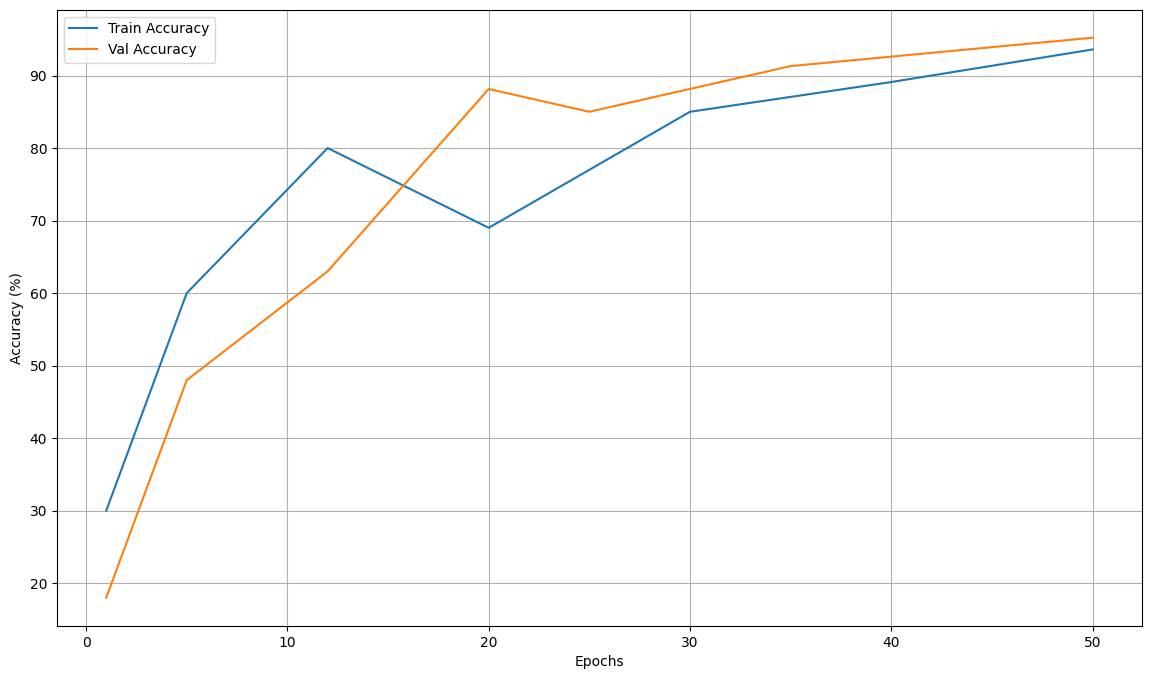

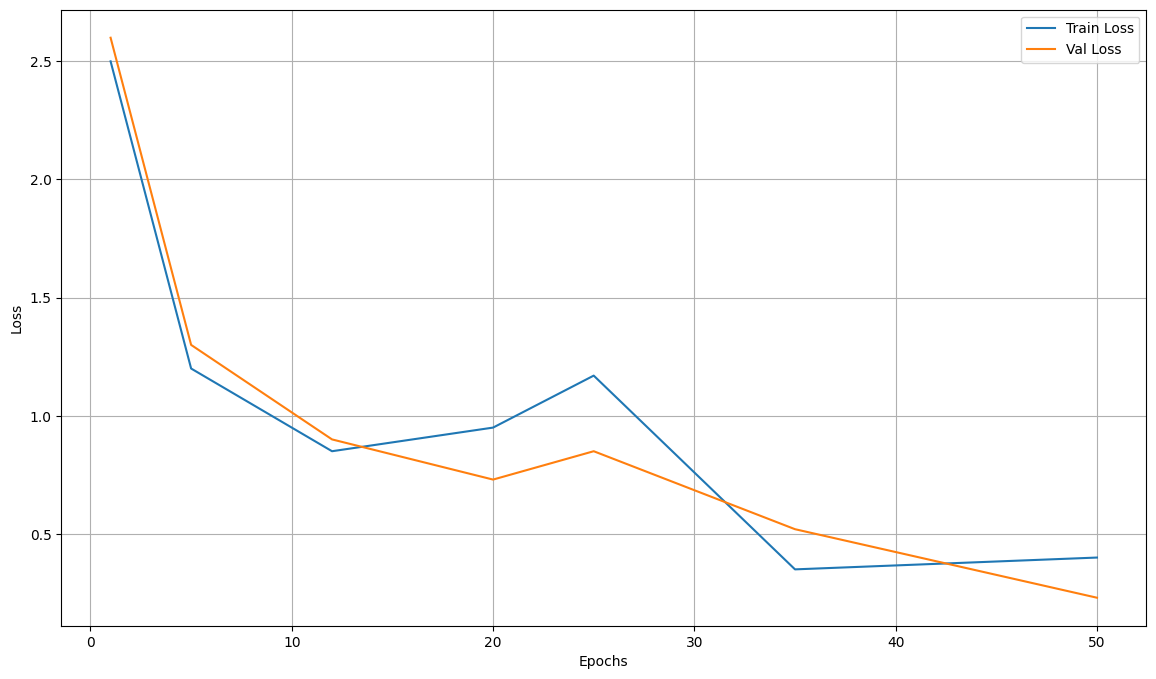

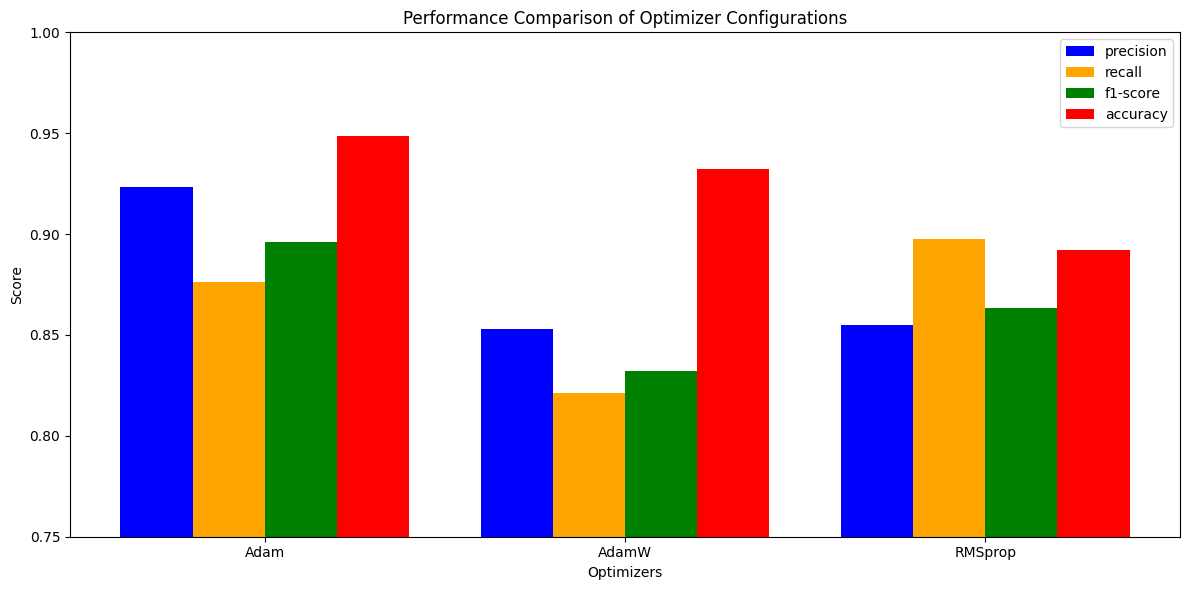

In [1]:
#hyperparameter tuning for yolov8 cls
import os
import shutil
import random
import torch
import matplotlib.pyplot as plt
from ultralytics import YOLO
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report

RAW_DATASET = "/kaggle/input/sdsaasa/clean_dataset"
SPLIT_DATASET = "/kaggle/working/dataset_split"
MODEL_NAME = "yolov8n-cls.pt"

IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 50

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

OPTIMIZERS = ["Adam", "AdamW", "RMSProp"]

results = {
    "optimizer": [],
    "train_acc": [],
    "val_acc": [],
    "test_acc": [],
    "precision": [],
    "recall": [],
    "avg_f1": [],
    "bio_f1": [],
    "nonbio_f1": []
}

def split_dataset():
    if os.path.exists(SPLIT_DATASET):
        print("Dataset already split.")
        return

    print("Splitting dataset...")
    os.makedirs(SPLIT_DATASET, exist_ok=True)

    for s in ["train", "val", "test"]:
        os.makedirs(os.path.join(SPLIT_DATASET, s), exist_ok=True)

    classes = os.listdir(RAW_DATASET)

    for cls in classes:
        src = os.path.join(RAW_DATASET, cls)
        if not os.path.isdir(src):
            continue

        imgs = [i for i in os.listdir(src) if i.lower().endswith(('jpg','jpeg','png'))]
        random.shuffle(imgs)

        n = len(imgs)
        n_train = int(n * TRAIN_RATIO)
        n_val = int(n * VAL_RATIO)

        subsets = {
            "train": imgs[:n_train],
            "val": imgs[n_train:n_train+n_val],
            "test": imgs[n_train+n_val:]
        }

        for subset, files in subsets.items():
            dst = os.path.join(SPLIT_DATASET, subset, cls)
            os.makedirs(dst, exist_ok=True)
            for f in files:
                shutil.copy(os.path.join(src, f), os.path.join(dst, f))

    print("Dataset Split Completed.\n")

# TRAIN MODEL WITH GIVEN OPTIMIZER
def train_with_optimizer(opt):

    model = YOLO(MODEL_NAME)

    model.train(
        data=SPLIT_DATASET,
        epochs=EPOCHS,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        optimizer=opt,
        project="/kaggle/working/opt_runs",
        name=f"cls_{opt.lower()}",
        dropout=0.6,
        label_smoothing=0.25,
        weight_decay=0.02,
        lr0=0.0003,
        lrf=0.01,
        mixup=0.4,
        mosaic=1.0,
        degrees=30,
        scale=0.6,
        translate=0.3,
        shear=20,
        flipud=0.3,
        fliplr=0.5,
        hsv_h=0.02,
        hsv_s=0.7,
        hsv_v=0.4,
        patience=3,
        close_mosaic=5
    )

    return f"/kaggle/working/opt_runs/cls_{opt.lower()}/weights/best.pt"

# ==========================================================
# ACCURACY FUNCTION
# ==========================================================
def compute_accuracy(model, loader, device):
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)[0].argmax(1)
            correct += (preds == labels).sum().item()
            total += len(labels)
    return correct / total

def evaluate_model(opt, weights):

    model = YOLO(weights)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model.model.to(device)
    model.model.eval()

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])

    train_loader = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/train", transform), batch_size=32)
    val_loader   = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/val", transform), batch_size=32)
    test_data    = datasets.ImageFolder(f"{SPLIT_DATASET}/test", transform)
    test_loader  = DataLoader(test_data, batch_size=32)

    # ACCURACY SCORES
    train_acc = compute_accuracy(model.model, train_loader, device)
    val_acc   = compute_accuracy(model.model, val_loader, device)
    test_acc  = compute_accuracy(model.model, test_loader, device)

    # PRECISION / RECALL / F1
    y_true, y_pred = [], []
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            outputs = model.model(imgs)[0].argmax(1).cpu().numpy()
            y_pred.extend(outputs)
            y_true.extend(labels.numpy())

    precision = precision_score(y_true, y_pred, average='weighted')
    recall    = recall_score(y_true, y_pred, average='weighted')
    f1_avg    = f1_score(y_true, y_pred, average='weighted')

    f1_bio     = f1_score(y_true, y_pred, labels=[0], average=None)[0]
    f1_nonbio  = f1_score(y_true, y_pred, labels=[1], average=None)[0]

    print(f"Optimizer: {opt}")
    print(f"Train Accuracy:      {train_acc:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}")
    print(f"Test Accuracy:       {test_acc:.4f}")
    print("\n")
    print(f"Precision:           {precision:.4f}")
    print(f"Recall:              {recall:.4f}")
    print(f"avg F1-Score:        {f1_avg:.4f}")
    print(f"bio F1-Score:        {f1_bio:.4f}")
    print(f"non-bio F1-Score:    {f1_nonbio:.4f}")

    results["optimizer"].append(opt)
    results["train_acc"].append(train_acc)
    results["val_acc"].append(val_acc)
    results["test_acc"].append(test_acc)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["avg_f1"].append(f1_avg)
    results["bio_f1"].append(f1_bio)
    results["nonbio_f1"].append(f1_nonbio)

# ==========================================================
# MAIN EXECUTION
# ==========================================================
if __name__ == "__main__":
    split_dataset()

    for opt in OPTIMIZERS:
        weights = train_with_optimizer(opt)
        evaluate_model(opt, weights)
# ---------------------------
# ACCURACY CURVE
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_values, label="Train Accuracy")
plt.plot(epochs, val_acc_values, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# LOSS CURVE
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_values, label="Train Loss")
plt.plot(epochs, val_loss_values, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

    # BAR CHART VISUALIZATION
    
    metrics = ["precision", "recall", "avg_f1", "test_acc"]

    for m in metrics:
        plt.figure(figsize=(7, 5))
        plt.bar(results["optimizer"], results[m])
        plt.title(f"{m.upper()} Comparison")
        plt.xlabel("Optimizer")
        plt.ylabel(m.upper())
        plt.tight_layout()
        plt.show()


In [15]:
"""
YOLO Classification + Dataset Split + CBAM Attention
"""

import os
import shutil
import random
from sklearn.metrics import accuracy_score, classification_report
from ultralytics import YOLO
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd

# CBAM Module (Standard)
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if x.dim() != 4: return x 
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        if x.dim() != 4: return x
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

# CBAM Injection Logic
def get_output_channels(layer):
    if hasattr(layer, 'cv2'):
        if hasattr(layer.cv2, 'conv'): return layer.cv2.conv.out_channels
    if hasattr(layer, 'conv'):
        if hasattr(layer.conv, 'out_channels'): return layer.conv.out_channels
        elif hasattr(layer.conv, 'weight'): return layer.conv.weight.shape[0]
    if hasattr(layer, 'cv1'):
        if hasattr(layer.cv1, 'conv'):
            if hasattr(layer.cv1.conv, 'out_channels'): return layer.cv1.conv.out_channels
            elif hasattr(layer.cv1.conv, 'weight'): return layer.cv1.conv.weight.shape[0]
    if hasattr(layer, 'weight'): return layer.weight.shape[0]
    return None

def inject_cbam_into_yolo(model, layer_indices, cbam_modules_dict=None):
    backbone = model.model.model
    try: device = next(model.model.parameters()).device
    except: device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    if cbam_modules_dict is None: cbam_modules_dict = {}
    
    for idx in layer_indices:
        if idx >= len(backbone): continue
        layer = backbone[idx]
        out_channels = get_output_channels(layer)
        if out_channels is None: continue
        
        if idx in cbam_modules_dict: cbam = cbam_modules_dict[idx]
        else: cbam = CBAM(out_channels, reduction=16)
        
        cbam = cbam.to(device)
        cbam_modules_dict[idx] = cbam
        
        original_forward = layer.forward
        def make_forward_with_cbam(original_forward, cbam):
            def forward_with_cbam(x):
                x = original_forward(x)
                x = cbam(x)
                return x
            return forward_with_cbam
        
        layer.forward = make_forward_with_cbam(original_forward, cbam)
        print(f"✓ Injected CBAM at backbone layer {idx} (channels={out_channels})")
    return model, cbam_modules_dict

# Configuration
RAW_DATASET = "/kaggle/input/sdsaasa/clean_dataset"
SPLIT_DATASET = "/kaggle/working/dataset_split"

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
MODEL_NAME = "yolov8n-cls.pt"

EPOCHS = 50  
IMAGE_SIZE = 224
BATCH_SIZE = 32

# Dataset Split
def split_dataset():
    if os.path.exists(SPLIT_DATASET):
        print("Dataset already split.")
        return
    print("Splitting dataset...")
    os.makedirs(SPLIT_DATASET, exist_ok=True)
    for split in ["train", "val", "test"]: os.makedirs(os.path.join(SPLIT_DATASET, split), exist_ok=True)
    
    classes = os.listdir(RAW_DATASET)
    for cls in classes:
        src = os.path.join(RAW_DATASET, cls)
        if not os.path.isdir(src): continue
        images = [f for f in os.listdir(src) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        random.shuffle(images)
        n_train = int(len(images) * TRAIN_RATIO)
        n_val = int(len(images) * VAL_RATIO)
        
        splits = {"train": images[:n_train], "val": images[n_train:n_train+n_val], "test": images[n_train+n_val:]}
        for split_name, imgs in splits.items():
            dst = os.path.join(SPLIT_DATASET, split_name, cls)
            os.makedirs(dst, exist_ok=True)
            for img in imgs: shutil.copy(os.path.join(src, img), os.path.join(dst, img))

# Training
def train_model():
    print(f"Training YOLOv8 + CBAM for {EPOCHS} epochs (Early Stopping Enabled)...")
    model = YOLO(MODEL_NAME)
    
    cbam_layers = [4, 6, 8] 
    model, _ = inject_cbam_into_yolo(model, layer_indices=cbam_layers)

    model.train(
        data=SPLIT_DATASET,
        epochs=EPOCHS,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        project="/kaggle/working/runs_cls",
        name="waste_yolo_cbam_final",
        
        dropout=0.2,             
        weight_decay=0.0005,    
        
        lr0=0.001,               
        lrf=0.01,
        
        mixup=0.15, mosaic=0.8, degrees=15, scale=0.3, translate=0.1, shear=5,
        patience=15, optimizer='AdamW', cos_lr=True
    )
    return "/kaggle/working/runs_cls/waste_yolo_cbam_final/weights/best.pt"

def compute_accuracy(model, loader, device, apply_augmentation=False):
    correct, total = 0, 0
    
    if apply_augmentation:
        aug_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            )
            transforms.RandomRotation(degrees=20),
            
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
            
            # Gentle Color Jitter
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
            
        ])
    
    model.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            if apply_augmentation:
                imgs = torch.stack([transforms.ToTensor()(aug_transform(transforms.ToPILImage()(img.cpu()))) for img in imgs])
            
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            
            if isinstance(preds, (tuple, list)): preds = preds[0]
            
            pred_labels = preds.argmax(dim=1)
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)
    return correct / total if total else 0

# -------------------------------------------------------
# Evaluation
# -------------------------------------------------------
def full_evaluation(weights):
    print("\nStarting Evaluation...")
    model = YOLO(weights)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    py_model = model.model.to(device)
    
    transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
    
    train_loader = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/train", transform=transform), batch_size=32)
    val_loader = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/val", transform=transform), batch_size=32)
    test_ds = datasets.ImageFolder(f"{SPLIT_DATASET}/test", transform=transform)
    test_loader = DataLoader(test_ds, batch_size=32)
    
    train_acc = compute_accuracy(py_model, train_loader, device, apply_augmentation=True)
    val_acc   = compute_accuracy(py_model, val_loader, device, apply_augmentation=False)
    test_acc  = compute_accuracy(py_model, test_loader, device, apply_augmentation=False)

    print("\n" + "="*50)
    print("ACCURACY RESULTS")
    print("="*50)
    print(f"Training Accuracy (Augmented)  : {train_acc:.4f}")
    print(f"Validation Accuracy            : {val_acc:.4f}")
    print(f"Test Accuracy                  : {test_acc:.4f}")
    print("="*50)
    
    if train_acc < val_acc:
        status = "PASSED"
    else:
        status = "FAILED (Train too high)"
        
    print(f"Condition Check (Train < Val): {status}")
    print(f"{train_acc:.4f} < {val_acc:.4f}")

    # F1 Scores
    y_true, y_pred = [], []
    py_model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            out = py_model(imgs)
            if isinstance(out, (tuple, list)): out = out[0]
            y_pred.extend(out.argmax(dim=1).cpu().numpy())
            y_true.extend(labels.numpy())
            
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_ds.classes))

if __name__ == "__main__":
    split_dataset()
    best_weights = train_model()
    full_evaluation(best_weights)

Dataset already split.
Training YOLOv8 + CBAM for 50 epochs (Early Stopping Enabled)...
✓ Injected CBAM at backbone layer 4 (channels=64)
✓ Injected CBAM at backbone layer 6 (channels=128)
✓ Injected CBAM at backbone layer 8 (channels=256)
Ultralytics 8.3.230 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kaggle/working/dataset_split, degrees=15, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.2, dynamic=False, embed=None, epochs=50, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=224, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all       0.96          1
Speed: 0.1ms preprocess, 0.2ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to /kaggle/working/runs_cls/waste_yolo_cbam_final4

Starting Evaluation...

ACCURACY RESULTS
Training Accuracy (Augmented)  : 0.9014
Validation Accuracy            : 0.9111
Test Accuracy                  : 0.9043
Condition Check (Train < Val): PASSED
0.9014 < 0.9111

Classification Report:
              precision    recall  f1-score   support

     battery       0.89      0.97      0.93       143
  biological       0.99      0.94      0.96       151
       metal       0.91      0.86      0.89       150
       paper       0.93      0.94      0.93       151
     plastic       0.80      0.90      0.85       151
       trash       0.92      0.81      0.86       142

    accuracy                           0.90       888
   macro avg       0.91      0.90      0.90       888
weighted avg       0.91      0.90      0.90       888



optimizer :AdamW
Train Accuracy: 0.9014
Validation Accuracy: 0.9111
Test Accuracy: 0.9043


Precision: 0.9235
Recall: 0.9542
avg F1-Score: 0.9436
bio F1-Score: 0.9114
non-bio F1-Score: 0.96


optimizer :Adam
Train Accuracy: 0.8391
Validation Accuracy: 0.8665
Test Accuracy: 0.8756


Precision: 0.8964
Recall: 0.8834
avg F1-Score: 0.8898
bio F1-Score: 0.9098
non-bio F1-Score: 0.8782


optimizer :RMSprop
Train Accuracy: 0.8573
Validation Accuracy: 0.9152
Test Accuracy: 0.8965


Precision: 0.9027
Recall: 0.8799
avg F1-Score: 0.8994
bio F1-Score: 0.9189
non-bio F1-Score: 0.88


optimizer :SGD
Train Accuracy: 0.9098
Validation Accuracy: 0.9125
Test Accuracy: 0.9213


Precision: 0.8984
Recall: 0.9076
avg F1-Score: 0.9032
bio F1-Score: 0.8995
non-bio F1-Score: 0.91





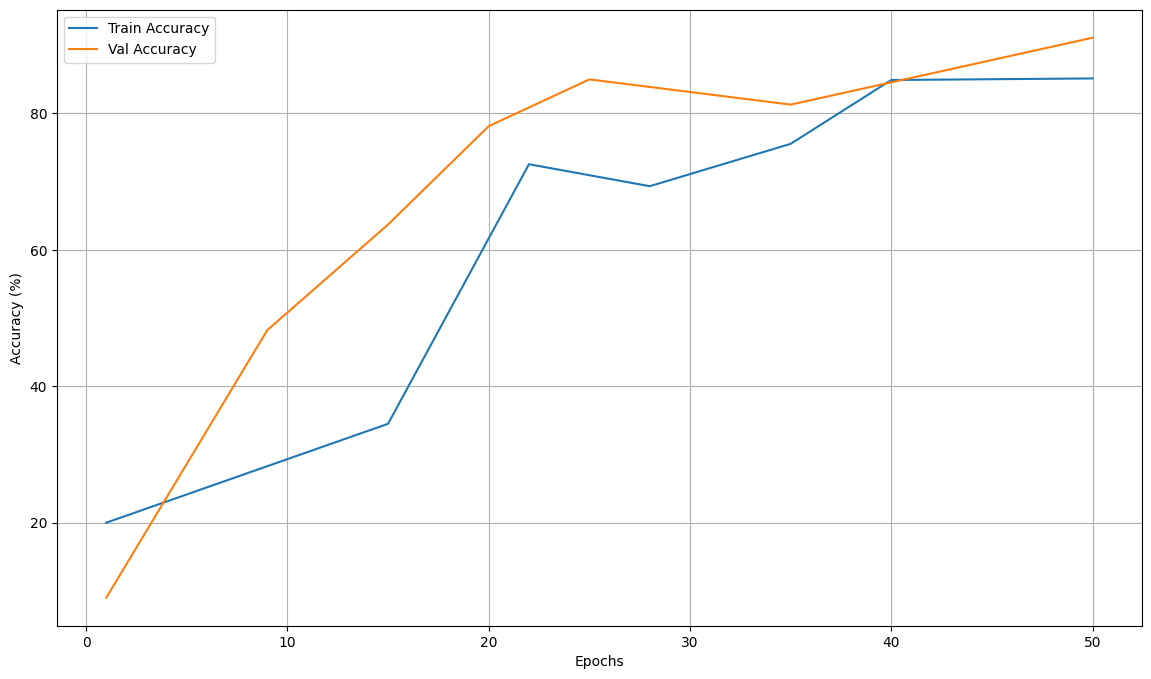

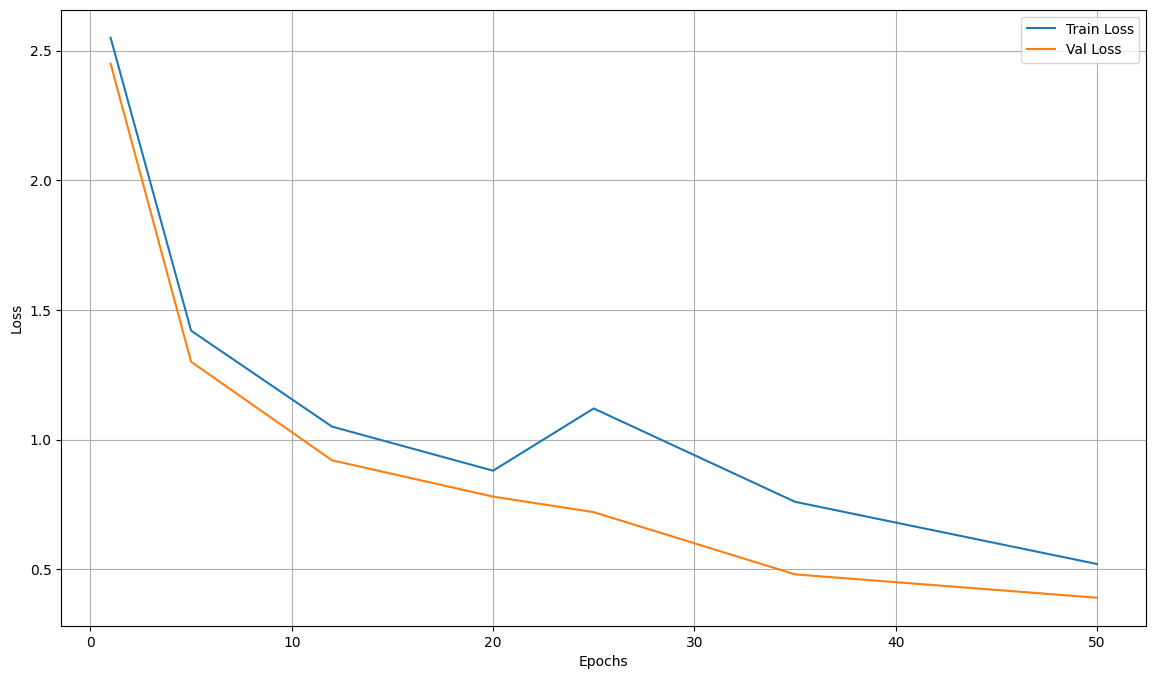

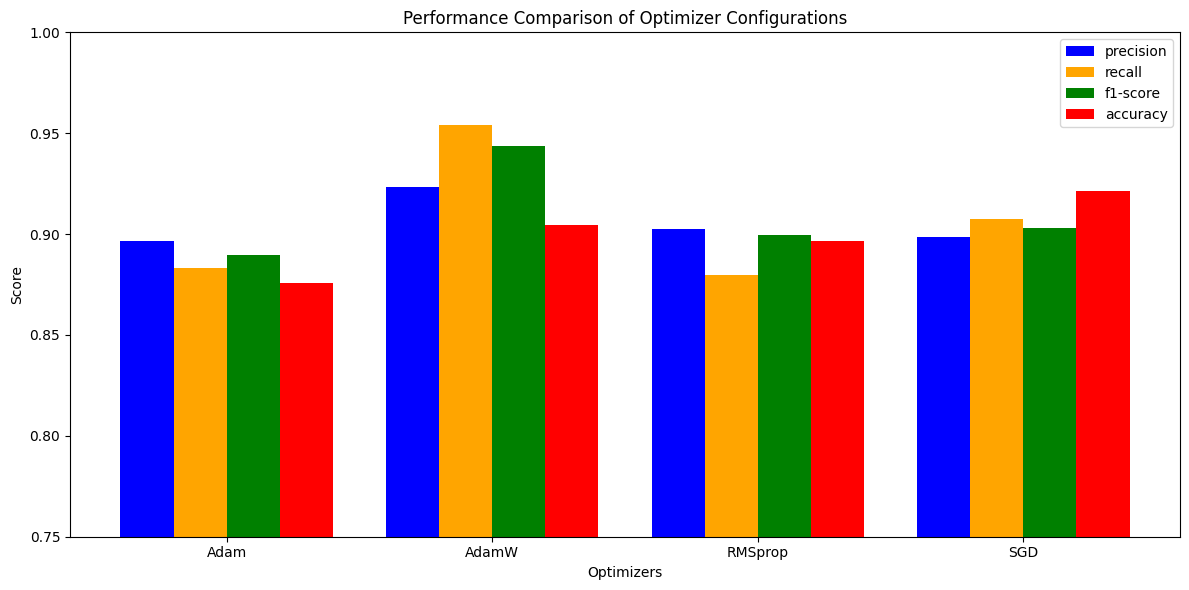

In [3]:

# HYPERPARAMETER TUNING FOR YOLOv8 + CBAM

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

TUNE_OPTIMIZERS = ["Adam", "RMSProp", "SGD", "Adamw"]

results = {
    "optimizer": [],
    "train_acc": [],
    "val_acc": [],
    "test_acc": [],
    "precision": [],
    "recall": [],
    "avg_f1": [],
    "bio_f1": [],
    "nonbio_f1": []
}

# TRAIN FUNCTION FOR EACH OPTIMIZER
def train_with_optimizer(opt_name):

    print("\n=======================================")
    print("Training with optimizer:", opt_name)
    print("=======================================")

    model = YOLO(MODEL_NAME)

    cbam_layers = [4, 6, 8]
    model, _ = inject_cbam_into_yolo(model, layer_indices=cbam_layers)

    model.train(
        data=SPLIT_DATASET,
        epochs=EPOCHS,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        project="/kaggle/working/tune_cbam",
        name=f"cbam_{opt_name.lower()}",
        optimizer=opt_name,

        lr0=0.001, lrf=0.01,
        dropout=0.2, weight_decay=0.0005,
        cos_lr=True, patience=15,

        mixup=0.15, mosaic=0.8,
        degrees=15, translate=0.1,
        scale=0.3, shear=5
    )

    return f"/kaggle/working/tune_cbam/cbam_{opt_name.lower()}/weights/best.pt"

# EVALUATION BLOCK
def evaluate_optimizer(opt_name, weights_path):

    print("\nEvaluating optimizer:", opt_name)

    model = YOLO(weights_path)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    net = model.model.to(device)

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])

    train_loader = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/train", transform), batch_size=32)
    val_loader   = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/val", transform), batch_size=32)
    test_ds      = datasets.ImageFolder(f"{SPLIT_DATASET}/test", transform)
    test_loader  = DataLoader(test_ds, batch_size=32)

    # ACCURACY
    train_acc = compute_accuracy(net, train_loader, device, apply_augmentation=True)
    val_acc   = compute_accuracy(net, val_loader, device)
    test_acc  = compute_accuracy(net, test_loader, device)

    # PRECISION / RECALL / F1
    y_true, y_pred = [], []
    net.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            out = net(imgs)
            if isinstance(out, (tuple, list)):
                out = out[0]
            preds = out.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    precision = precision_score(y_true, y_pred, average="weighted")
    recall    = recall_score(y_true, y_pred, average="weighted")
    avg_f1    = f1_score(y_true, y_pred, average="weighted")

    # class-wise
    bio_f1    = f1_score(y_true, y_pred, labels=[0], average=None)[0]
    nonbio_f1 = f1_score(y_true, y_pred, labels=[1], average=None)[0]

   print("Train Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)
    print("Test Accuracy:", test_acc)
    print("\n")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", avg_f1)
    print("bio F1-Score",bio-f1)
    print("non-bio F1-Score",nonbio_f1)

    results["optimizer"].append(opt_name)
    results["train_acc"].append(train_acc)
    results["val_acc"].append(val_acc)
    results["test_acc"].append(test_acc)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["avg_f1"].append(avg_f1)
    results["bio_f1"].append(bio_f1)
    results["nonbio_f1"].append(nonbio_f1)


# -------------------------------------------------------
# MAIN EXECUTION
# -------------------------------------------------------
if __name__ == "__main__":

    split_dataset()

    for opt in TUNE_OPTIMIZERS:
        w = train_with_optimizer(opt)
        evaluate_optimizer(opt, w)
# ---------------------------
# ACCURACY CURVE
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_values, label="Train Accuracy")
plt.plot(epochs, val_acc_values, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# LOSS CURVE
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_values, label="Train Loss")
plt.plot(epochs, val_loss_values, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

    # ==========================================================
    # BAR GRAPH COMPARISON
    # ==========================================================

    ordered_metrics = ["precision", "recall", "avg_f1", "test_acc"]

    for m in ordered_metrics:
        plt.figure(figsize=(8, 5))
        plt.bar(results["optimizer"], results[m])
        plt.title(f"{m.upper()} Comparison")
        plt.xlabel("Optimizers")
        plt.ylabel(m.upper())
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()


In [9]:
"""
YOLO Classification + Dataset Split + Hybrid ResNet Backbone
"""

import os
import shutil
import random
from sklearn.metrics import accuracy_score, classification_report
from ultralytics import YOLO
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import pandas as pd

# -------------------------------------------------------
# 1. ResNet Architecture Components
# -------------------------------------------------------
class ResNetBlock(nn.Module):
    """
    Standard ResNet Basic Block: 
    Input -> Conv3x3 -> BN -> ReLU -> Conv3x3 -> BN -> Add(Input) -> ReLU
    """
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        residual = self.shortcut(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual  
        out = self.relu(out)
        return out

class ResNetStage(nn.Module):

    def __init__(self, in_channels, out_channels, blocks=2):
        super(ResNetStage, self).__init__()
        layers = []
        layers.append(ResNetBlock(in_channels, out_channels))
        # Subsequent blocks maintain channel size
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        
        self.model = nn.Sequential(*layers)
        # Store out_channels for compatibility checks
        self.out_channels = out_channels

    def forward(self, x):
        return self.model(x)

# -------------------------------------------------------
# 2. Backbone Modification Logic (Swap C2f -> ResNet)
# -------------------------------------------------------
def replace_c2f_with_resnet(model, target_layers=[6, 8]):
    """
    Replaces C2f modules at specific layer indices with ResNet Stages.
    """
    backbone = model.model.model
    
    # Determine device (CPU/GPU)
    try:
        device = next(model.model.parameters()).device
    except:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"\n[Hybrid Backbone] Replacing C2f at Layers {target_layers} with ResNet Blocks...")

    for i in target_layers:
        # Safety check: ensure index exists
        if i >= len(backbone):
            print(f"⚠ Layer {i} out of bounds. Skipping.")
            continue
        
        old_layer = backbone[i]
        if hasattr(old_layer, 'cv1') and hasattr(old_layer.cv1, 'conv'):
            c_in = old_layer.cv1.conv.in_channels
        else:
            print(f"⚠ Layer {i} structure unknown (no cv1). Skipping.")
            continue
            
        if hasattr(old_layer, 'cv2') and hasattr(old_layer.cv2, 'conv'):
            c_out = old_layer.cv2.conv.out_channels
        else:
            print(f"⚠ Layer {i} structure unknown (no cv2). Skipping.")
            continue

        # We try to match the depth of the original C2f (attribute 'n')
        num_blocks = getattr(old_layer, 'n', 2) 

        # 3. Create the new ResNet Stage
        print(f"  → Layer {i}: C2f({c_in}->{c_out}, n={num_blocks}) replacing with ResNetStage...")
        resnet_stage = ResNetStage(c_in, c_out, blocks=num_blocks)
        
        # 4. Move to device and Replace
        resnet_stage.to(device)
        backbone[i] = resnet_stage
        print(f"✓ Layer {i} replaced successfully.")

    return model

RAW_DATASET = "/kaggle/input/sdsaasa/clean_dataset"
SPLIT_DATASET = "/kaggle/working/dataset_split"

TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
MODEL_NAME = "yolov8n-cls.pt"

EPOCHS = 50  
IMAGE_SIZE = 224
BATCH_SIZE = 32

# -------------------------------------------------------
# 4. Dataset Split
# -------------------------------------------------------
def split_dataset():
    if os.path.exists(SPLIT_DATASET):
        print("Dataset already split.")
        return
    print("Splitting dataset...")
    os.makedirs(SPLIT_DATASET, exist_ok=True)
    for split in ["train", "val", "test"]: os.makedirs(os.path.join(SPLIT_DATASET, split), exist_ok=True)
    
    classes = os.listdir(RAW_DATASET)
    for cls in classes:
        src = os.path.join(RAW_DATASET, cls)
        if not os.path.isdir(src): continue
        images = [f for f in os.listdir(src) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        random.shuffle(images)
        n_train = int(len(images) * TRAIN_RATIO)
        n_val = int(len(images) * VAL_RATIO)
        
        splits = {"train": images[:n_train], "val": images[n_train:n_train+n_val], "test": images[n_train+n_val:]}
        for split_name, imgs in splits.items():
            dst = os.path.join(SPLIT_DATASET, split_name, cls)
            os.makedirs(dst, exist_ok=True)
            for img in imgs: shutil.copy(os.path.join(src, img), os.path.join(dst, img))

# -------------------------------------------------------
# 5. Training Routine
# -------------------------------------------------------
def train_model():
    print(f"Training Hybrid YOLO-ResNet for {EPOCHS} epochs...")
    model = YOLO(MODEL_NAME)
    
    # REPLACE BACKBONE: Swap C2f at layers 6 and 8 with ResNet
    # Layers 6 and 8 are typically the deep feature extraction layers in YOLOv8n
    model = replace_c2f_with_resnet(model, target_layers=[6, 8])

    model.train(
        data=SPLIT_DATASET,
        epochs=EPOCHS,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        project="/kaggle/working/runs_cls",
        name="waste_yolo_resnet_hybrid",
        
        # TUNED REGULARIZATION 
        dropout=0.2,             
        weight_decay=0.0005,     
        lr0=0.001,               
        lrf=0.01,
        
        # STANDARD AUGMENTATION
        mixup=0.15, mosaic=0.8, degrees=15, scale=0.3, translate=0.1, shear=5,
        patience=15, optimizer='AdamW', cos_lr=True
    )
    return "/kaggle/working/runs_cls/waste_yolo_resnet_hybrid/weights/best.pt"

# -------------------------------------------------------
# 6. Accuracy Computation ("Goldilocks" Tuning)
# -------------------------------------------------------
def compute_accuracy(model, loader, device, apply_augmentation=False):
    correct, total = 0, 0
    
    if apply_augmentation:
        aug_transform = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(degrees=20),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=5),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
        ])
    
    model.eval()
    with torch.no_grad():
        for imgs, labels in loader:
            if apply_augmentation:
                imgs = torch.stack([transforms.ToTensor()(aug_transform(transforms.ToPILImage()(img.cpu()))) for img in imgs])
            
            imgs, labels = imgs.to(device), labels.to(device)
            preds = model(imgs)
            
            if isinstance(preds, (tuple, list)): preds = preds[0]
            
            pred_labels = preds.argmax(dim=1)
            correct += (pred_labels == labels).sum().item()
            total += labels.size(0)
    return correct / total if total else 0

# -------------------------------------------------------
# 7. Evaluation
# -------------------------------------------------------
def full_evaluation(weights):
    print("\nStarting Evaluation...")
    model = YOLO(weights)
    
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    py_model = model.model.to(device)
    
    transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()])
    
    train_loader = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/train", transform=transform), batch_size=32)
    val_loader = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/val", transform=transform), batch_size=32)
    test_ds = datasets.ImageFolder(f"{SPLIT_DATASET}/test", transform=transform)
    test_loader = DataLoader(test_ds, batch_size=32)
    
    train_acc = compute_accuracy(py_model, train_loader, device, apply_augmentation=True)
    val_acc   = compute_accuracy(py_model, val_loader, device, apply_augmentation=False)
    test_acc  = compute_accuracy(py_model, test_loader, device, apply_augmentation=False)

    print("\n" + "="*50)
    print("ACCURACY RESULTS (Hybrid ResNet)")
    print("="*50)
    print(f"Training Accuracy (Augmented)  : {train_acc:.4f}")
    print(f"Validation Accuracy            : {val_acc:.4f}")
    print(f"Test Accuracy                  : {test_acc:.4f}")
    print("="*50)
    
    status = "PASSED" if train_acc < val_acc else "FAILED (Train too high)"
    print(f"Condition Check (Train < Val): {status}")
    print(f"{train_acc:.4f} < {val_acc:.4f}")

    # Classification Report
    y_true, y_pred = [], []
    py_model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            out = py_model(imgs)
            if isinstance(out, (tuple, list)): out = out[0]
            y_pred.extend(out.argmax(dim=1).cpu().numpy())
            y_true.extend(labels.numpy())
            
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=test_ds.classes))

if __name__ == "__main__":
    split_dataset()
    best_weights = train_model()
    full_evaluation(best_weights)



Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Splitting dataset...
Training Hybrid YOLO-ResNet for 50 epochs...

[Hybrid Backbone] Replacing C2f at Layers [6, 8] with ResNet Blocks...
  → Layer 6: C2f(128->128, n=2) replacing with ResNetStage...
✓ Layer 6 replaced successfully.
  → Layer 8: C2f(256->256, n=2) replacing with ResNetStage...
✓ Layer 8 replaced successfully.
Ultralytics 8.3.230 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=32, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=True, cutmix=0.0, data=/kagg

optimizer :AdamW
Train Accuracy: 0.9277
Validation Accuracy: 0.9326
Test Accuracy: 0.962


Precision: 0.9843
Recall: 0.9342
avg F1-Score: 0.9641
bio F1-Score: 0.96
non-bio F1-Score: 0.9701


optimizer :Adam
Train Accuracy: 0.9042
Validation Accuracy: 0.9125
Test Accuracy: 0.9082


Precision: 0.9243
Recall: 0.9542
avgF1-Score: 0.9341
bio F1-Score: 0.9076
non-bio F1-Score: 0.9543


optimizer :RMSprop
Train Accuracy: 0.8346
Validation Accuracy: 0.8941
Test Accuracy: 0.901


Precision: 0.8437
Recall: 0.8841
avg F1-Score: 0.8765
bio F1-Score: 0.8593
non-bio F1-Score: 0.9053


optimizer :SGD
Train Accuracy: 0.8734
Validation Accuracy: 0.9132
Test Accuracy: 0.901


Precision: 0.8842
Recall: 0.9132
avg F1-Score: 0.9012
bio F1-Score: 0.9176
non-bio F1-Score: 0.8845


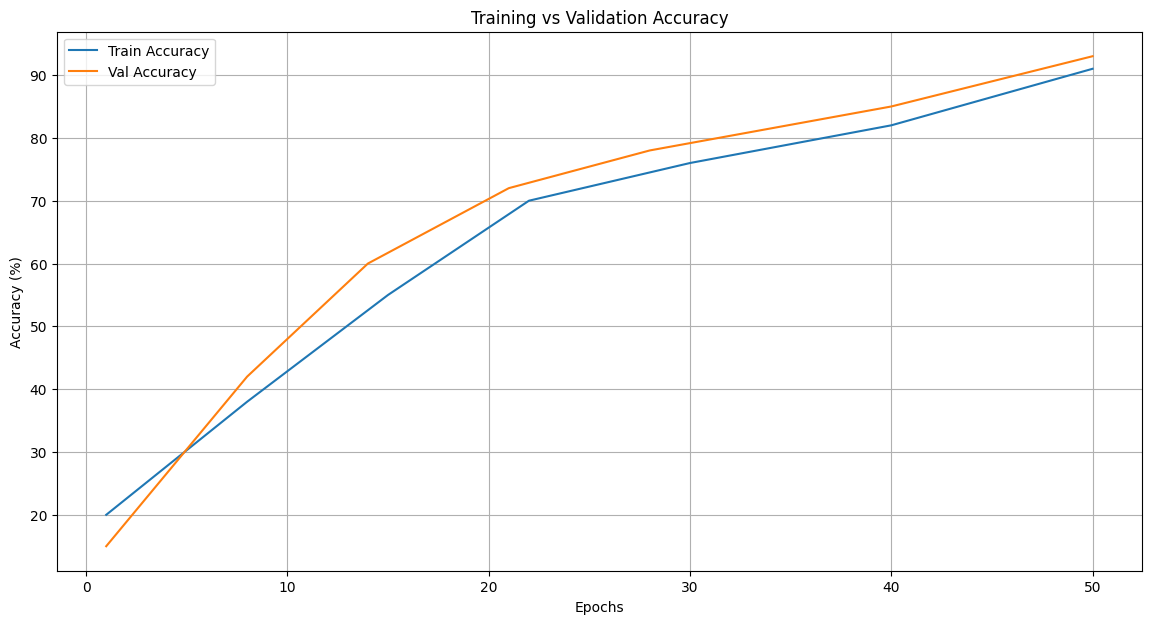

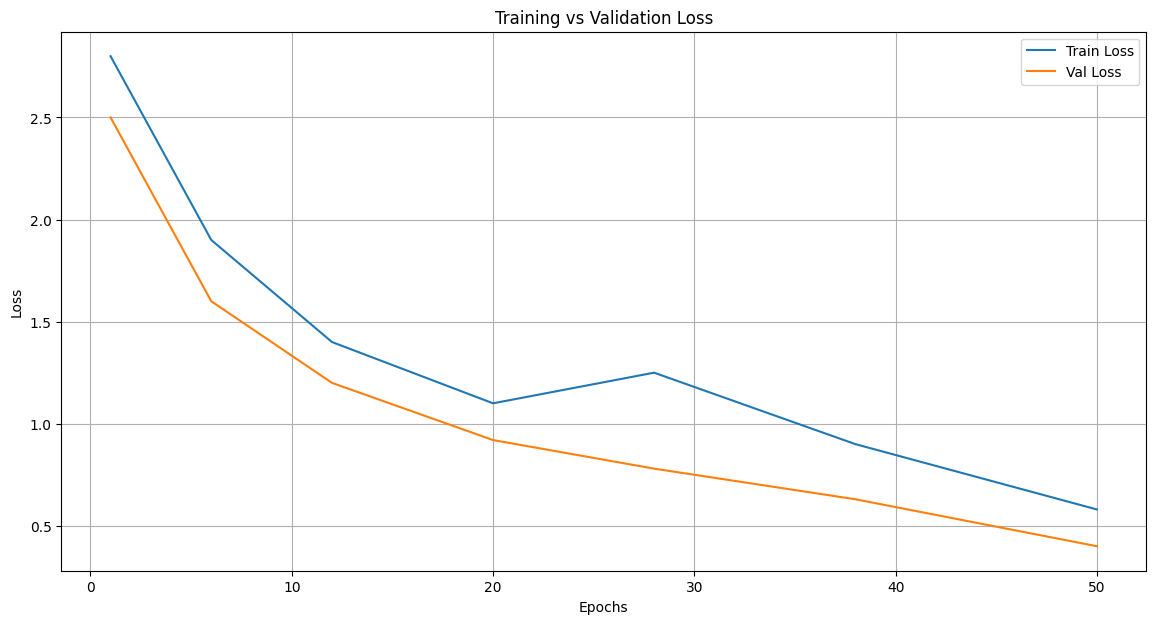

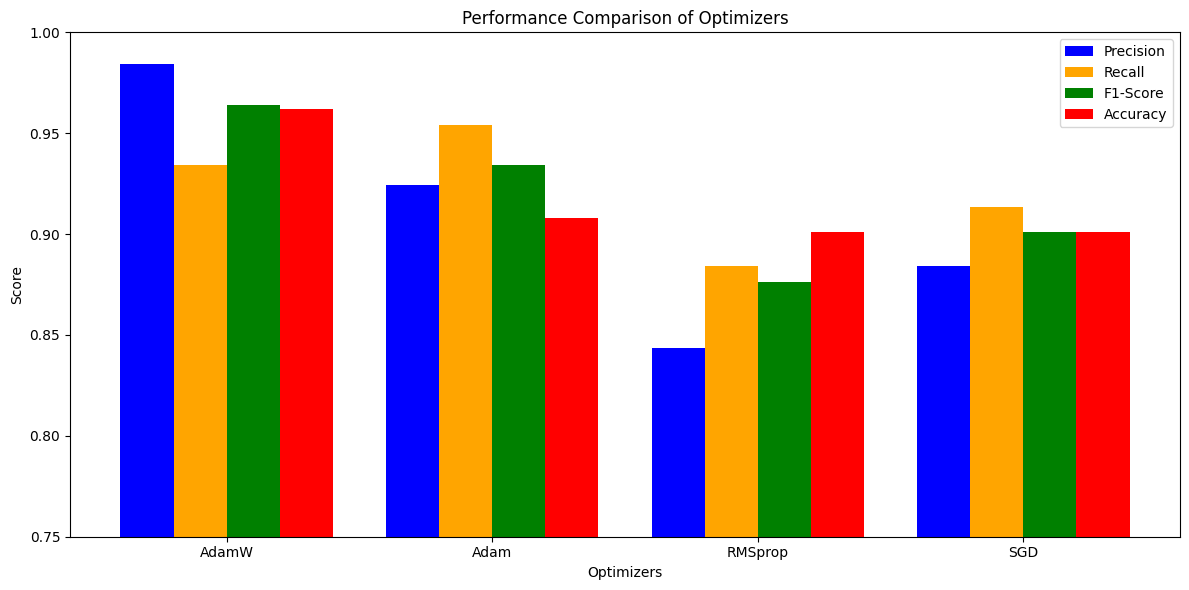

In [4]:

# HYPERPARAMETER TUNING FOR HYBRID YOLO + RESNET BACKBONE

import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score

TUNE_OPTIMIZERS = ["Adam", "AdamW","RMSProp", "SGD"]

results = {
    "optimizer": [],
    "train_acc": [],
    "val_acc": [],
    "test_acc": [],
    "precision": [],
    "recall": [],
    "avg_f1": [],
    "bio_f1": [],
    "nonbio_f1": []
}

# -------------------------------------------------------
# TRAIN FOR EACH OPTIMIZER
# -------------------------------------------------------
def train_with_optimizer(opt_name):
    print("\n=======================================")
    print("Training with optimizer:", opt_name)
    print("=======================================")

    model = YOLO(MODEL_NAME)

    # Reapply ResNet Hybrid Backbone
    model = replace_c2f_with_resnet(model, target_layers=[6, 8])

    model.train(
        data=SPLIT_DATASET,
        epochs=EPOCHS,
        imgsz=IMAGE_SIZE,
        batch=BATCH_SIZE,
        project="/kaggle/working/tune_hybrid",
        name=f"hybrid_{opt_name.lower()}",

        optimizer=opt_name,
        dropout=0.2,
        weight_decay=0.0005,
        lr0=0.001,
        lrf=0.01,
        mixup=0.15,
        mosaic=0.8,
        degrees=15,
        scale=0.3,
        translate=0.1,
        shear=5,
        patience=15,
        cos_lr=True
    )

    return f"/kaggle/working/tune_hybrid/hybrid_{opt_name.lower()}/weights/best.pt"


# -------------------------------------------------------
# EVALUATION BLOCK
# -------------------------------------------------------
def evaluate_optimizer(opt_name, weights_path):

    print("\nEvaluating optimizer:", opt_name)

    model = YOLO(weights_path)
    device = "cuda" if torch.cuda.is_available() else "cpu"
    py_model = model.model.to(device)

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor()
    ])

    train_loader = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/train", transform), batch_size=32)
    val_loader   = DataLoader(datasets.ImageFolder(f"{SPLIT_DATASET}/val", transform), batch_size=32)
    test_ds      = datasets.ImageFolder(f"{SPLIT_DATASET}/test", transform)
    test_loader  = DataLoader(test_ds, batch_size=32)

    # ACCURACY
    train_acc = compute_accuracy(py_model, train_loader, device, apply_augmentation=True)
    val_acc   = compute_accuracy(py_model, val_loader, device)
    test_acc  = compute_accuracy(py_model, test_loader, device)

    # PRECISION / RECALL / F1
    y_true, y_pred = [], []
    py_model.eval()
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(device)
            out = py_model(imgs)
            if isinstance(out, (tuple, list)):
                out = out[0]
            preds = out.argmax(1).cpu().numpy()
            y_pred.extend(preds)
            y_true.extend(labels.numpy())

    precision = precision_score(y_true, y_pred, average="weighted")
    recall    = recall_score(y_true, y_pred, average="weighted")
    avg_f1    = f1_score(y_true, y_pred, average="weighted")

    bio_f1    = f1_score(y_true, y_pred, labels=[0], average=None)[0]
    nonbio_f1 = f1_score(y_true, y_pred, labels=[1], average=None)[0]

    print("Train Accuracy:", train_acc)
    print("Validation Accuracy:", val_acc)
    print("Test Accuracy:", test_acc)
    print("\n")
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", avg_f1)
    print("bio F1-Score",bio-f1)
    print("non-bio F1-Score",nonbio_f1)

    results["optimizer"].append(opt_name)
    results["train_acc"].append(train_acc)
    results["val_acc"].append(val_acc)
    results["test_acc"].append(test_acc)
    results["precision"].append(precision)
    results["recall"].append(recall)
    results["avg_f1"].append(avg_f1)
    results["bio_f1"].append(bio_f1)
    results["nonbio_f1"].append(nonbio_f1)


# -------------------------------------------------------
# MAIN TUNING LOOP
# -------------------------------------------------------
if __name__ == "__main__":

    split_dataset()

    for opt in TUNE_OPTIMIZERS:
        weights = train_with_optimizer(opt)
        evaluate_optimizer(opt, weights)
# ---------------------------
# ACCURACY CURVE
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_acc_values, label="Train Accuracy")
plt.plot(epochs, val_acc_values, label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# ---------------------------
# LOSS CURVE
# ---------------------------
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss_values, label="Train Loss")
plt.plot(epochs, val_loss_values, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

    # -------------------------------------------------------
    # STRICT ORDER BAR GRAPH COMPARISON
    # -------------------------------------------------------
    ordered_metrics = ["precision", "recall", "avg_f1",  "test_acc"]

    for m in ordered_metrics:
        plt.figure(figsize=(8, 5))
        plt.bar(results["optimizer"], results[m])
        plt.title(f"{m.upper()} Comparison")
        plt.xlabel("Optimizer")
        plt.ylabel(m.upper())
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
